# Policy Evaluation

**Balancing immediate and long-term goals is challenging**. We experience this point every day: should I watch movies tonight or keep studying reinforcement learning? The first choice has an **immediate satisfaction**, the second on the other hand, won’t really give us much tonight, but **maybe (and only maybe)** will provide much **higher satisfaction in the long term**. How much more satisfaction in the long term, exactly, we may ask. I don’t know, you don’t know, and we won’t know unless we try it out, **unless we explore it**. **Life doesn’t give us its MDP!** life is uncertain. We need to balance information gathering and information utilization, **taking into account the long-term effect and not only the current situation**. We will study agents that can **learn to estimate the value of policies**, similar to the DP policy-evaluation method, but this time without the MDP. We need to recap some important concepts:

- The **reward** refers to the one-step signal the agent gets: the agent observes a state, selects an action, and receives a reward signal. It is the core of RL, but **it is not what the agent is trying to maximize**. While our agent maximizes the one-step reward, in the long-term, it’s getting less than it could.
- The **return** refers to the total discounted rewards, from any state until the end of the episode. It is a better indicators of performance, because it contains a long-term sequence, an history of rewards. But the return **isn’t what an agent tries to maximize**, either. An agent who attempts to obtain the highest possible return may find a policy that takes it through a noisy path; sometimes, this path will provide a high return, but perhaps most of the time a low one.
- The **value function** refers to the **expectation of return**. We want high returns, but high on average (expectation). If the agent is in a noisy environment, or if the agent is using a stochastic policy, it’s all fine. 

The agent **is trying to maximize the expected total discounted reward: the value function**. 

## Random Walk Environment

A single-row grid-world environment, with five non-terminal states. The probability of going left when taking the "left" action is equal to the probability of going right, and the probability of going right when taking the "right" action is equal to the probability of going left. In other words, **the agent has no control of where it goes**. This environment is useful **to focus on the prediction problem**, in which there is no need to distinguish the dynamics due to the environment from those due to the agent. 

![](./images/random-walk-environment.png)

In [1]:
import numpy as np
    
class RandomWalk:
    """
    State Index:   [ 0    1    2    3    4    5    6 ]
    State Label:   [ .    A    B    C    D    E    . ]
    Type:          [ T    .    .    S    .    .    T ]    
    """
    v_true =       [0.0, 1/6, 2/6, 3/6, 4/6, 5/6, 0.0]
    
    def __init__(self):
        self.reset()

    def reset(self):
        self.observation_space = 7
        self.state = np.random.choice([1,2,3,4,5])
        self.terminated = False
        return self.state

    def step(self, action):     
        self.state += np.random.choice([-1, 1])
        
        reward = 0
        
        if self.state < 1: 
            self.terminated = True
        
        if self.state > 5: 
            self.terminated = True; 
            reward = 1
        
        return self.state, reward, self.terminated, 0, 0  # obs, rew, terminated, truncated, info

In [2]:
random_walk = RandomWalk()

The dynamics of this environment make policy being evaluated irrelevant, so we select an all-left policy:

In [3]:
def pi(state):
    return 1

## Improving estimates after each episode: Monte Carlo

The goal is to estimate the state-value function of a policy (the expectation of returns): 

$\displaystyle v_{\pi}(s) = E_{\pi}(G_{t:T} | S_t=s)$

The most straightforward approach that comes to mind is **to run several episodes** with the policy under evaluation, **collecting hundreds of trajectories** (collections of **experiences** like [state, action, reward, next state]) and then **calculate averages** for every state. 

![](./images/trajectory.png)

This method is called **Monte Carlo prediction (MC)** and it is easy to implement. Given a trajectory:

$\displaystyle S_t, A_t, R_{t+1}, S_{t+1}$

$\displaystyle S_{t+1}, A_{t+1}, R_{t+2}, S_{t+2}$

$\displaystyle ...$

$\displaystyle S_{T-1}, A_{T-1}, R_T, S_T$

We calculate the return for every state encountered by adding and discounting the rewards received along the way, until the end of the trajectory at time step T: 

$\displaystyle G_{t:T} = R_{t+1} + \gamma R_{t+2} + ... + \gamma^{T-1}R_T$

Then, add up the per-state returns and increment a count:

$\displaystyle T(S_t) = T(S_t) + G_{t:T}$

$\displaystyle N(S_t) = N(S_t) + 1$

Finally, we can estimate the expectation using the empirical mean:

$\displaystyle V(S_t) = \frac{T(S_t)}{N({S_t})}$

As the counts approach infinity, the estimate will approach the true value:

$\displaystyle N(s) \longrightarrow \infty \Rightarrow V(s) \longrightarrow v_{\pi}(s)$

Notice that means can be calculated incrementally, there’s no need to keep track of the sum of returns for all states. This equation is equivalent and more efficient:

$\displaystyle V(S_t) = V(S_t) + \frac{G_{t:T} - V(S_t)}{N({S_t})}$

On this, we can replace the mean for a learning value that can be time dependent or constant:

$\displaystyle V(S_t) = V(S_t) + \alpha_t [G_{t:T} - V(S_t)]$

Where $G_{t:T}$ is the **MC target** and $G_{t:T} - V(S_t)$ is the **MC error**. Notice that V is calculated only at the end of an episode, because the returns depends on it. In practice, there are two different ways of implementing the algorithm. A single trajectory **may contain multiple visits to the same state**. Should we calculate the returns following each of those visits independently and then **include all** of those targets in the averages, or should we only use the **first visit** to each state? Both are valid approaches, and they have similar theoretical properties. The more standard version is **first-visit Monte Carlo (FVMC)**, and its convergence properties are easy to justify. **Every-visit Monte Carlo (EVMC)** is slightly different but has also been proven to converge given infinite samples. 

We can implement this method in Python. First of all, we write a function in order to calculate an exponentially decaying schedule to calculate all the values for alpha for the full process, we use the NumPy "logspace" function that returns evenly spaced numbers on a log scale. This hyperparameter is essential. **Often, alpha is a positive constant less than 1**. Having **a constant alpha helps with learning in non-stationary environments**. However, we can decay alpha in order to **show convergence**: alpha starts at a value, then it decreases exponentially to a min value in a number of episodes out of the total episodes. In that way alpha helps the algorithms get close to converging, but because alpha don't goes to zero, they don’t fully converge. We will use the same schedule in all algorithms.

In [4]:
import numpy as np

def decay_alpha(init_value, min_value, decay_steps, max_steps):

    # calculate the number of the remaining steps after the decay
    rem_steps = max_steps - decay_steps
    
    # logspace returns numbers spaced evenly on a log scale
    # base^start is the starting value of the sequence,
    # base^stop is the final value of the sequence
    # num is the number of values to generate
    # base is the base of the log space
    values = np.logspace(start=0, stop=-2, num=decay_steps, base=10)
    
    # because the values may not end exactly at 0, given it’s the log, 
    # we change them to be between 0 and 1 so that the curve looks smooth and nice.
    values = (values - values.min()) / (values.max() - values.min())
    
    # linear transformation and get points between init_value and min_value
    values = (init_value - min_value) * values + min_value
    
    # repeats the rightmost value rem_step number of times
    values = np.pad(values, (0, rem_steps), 'edge')
    
    return values

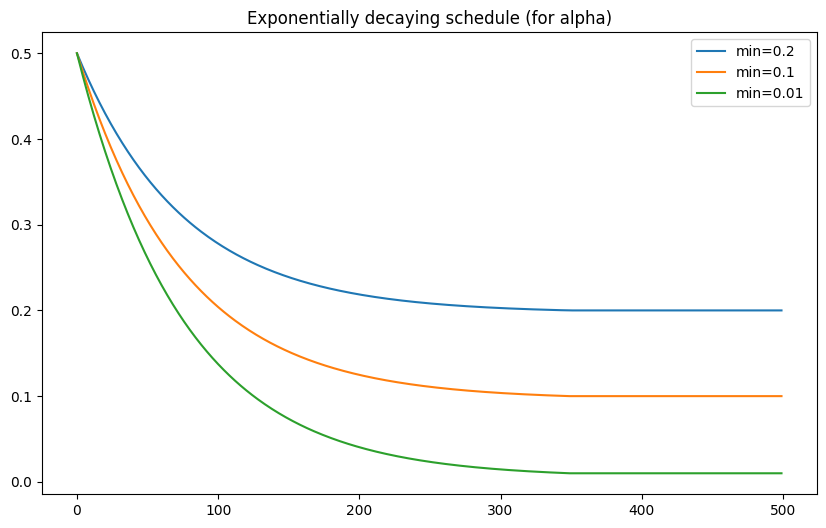

In [5]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10,6))
plt.plot(decay_alpha(0.5, 0.2, 350, 500), label='min=0.2')
plt.plot(decay_alpha(0.5, 0.1, 350, 500), label='min=0.1')
plt.plot(decay_alpha(0.5, 0.01, 350, 500), label='min=0.01')
plt.title('Exponentially decaying schedule (for alpha)')
plt.legend()
plt.show()

We need to discount the rewards collected during a trajectory with an exponentially decaying discount factor ($\gamma^0$ , $\gamma^1$ , $\gamma^2$,...), so we can reuse the "linspace" function to calculate all the discount values for the full process:

In [14]:
def decay_discounts(gamma, max_steps):
    discounts = np.logspace(start=0, stop=max_steps, num=max_steps, base=gamma, endpoint=False);
    return discounts

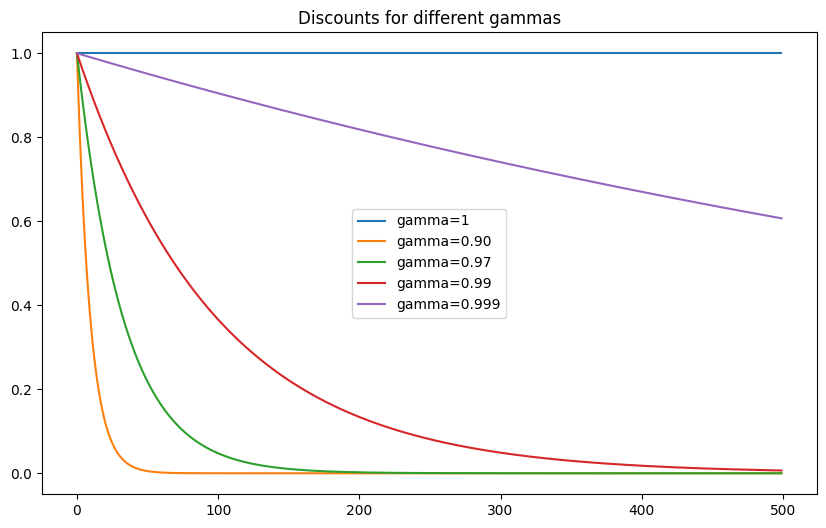

In [15]:
plt.figure(figsize=(10,6))
plt.plot(decay_discounts(1, 500), label='gamma=1')
plt.plot(decay_discounts(0.90, 500), label='gamma=0.90')
plt.plot(decay_discounts(0.97, 500), label='gamma=0.97')
plt.plot(decay_discounts(0.99, 500), label='gamma=0.99')
plt.plot(decay_discounts(0.999, 500), label='gamma=0.999')
plt.title('Discounts for different gammas')
plt.legend()
plt.show()

Then we write a function to run a policy over an environment and to extract a trajectory:

In [16]:
def generate_trajectory(pi, env, max_steps=200):
    
    # list of experiences (trajectory)
    trajectory = []
    
    done = False
    steps = 0
    
    # reset the environment to interact in a new episode
    state = env.reset()

    # looping through until the done flag is set to true
    while not done:     
        steps += 1;   

        # use the policy function to pick an action
        action = pi(state) 
            
        # step the environment using that action 
        next_state, reward, terminated, truncated, info = env.step(action)
        if(terminated or truncated):
            done = True;
        
        # append the experience to the trajectory
        experience = (state, action, reward, next_state, done)
        trajectory.append(experience)
            
        # if we hit a terminal state break and return
        if done:
            break;
                
        # truncate long trajectories
        if steps >= max_steps:
            break;
            
        # update the state
        state = next_state
            
    # return the trajectory
    return np.array(trajectory, object)

Now we can write the MC prediction function using the first-visit version:

In [17]:
def mc(pi, env, gamma=1.0, init_alpha=0.5, min_alpha=0.01, decay_episodes=350, n_episodes=500, max_steps=200):
    # calculate all discounts at once 
    discounts = decay_discounts(gamma, max_steps);
    
    # calculate all alphas at once
    alphas = decay_alpha(init_alpha, min_alpha, decay_episodes, n_episodes);
    
    # initialize the current estimate of the state-value function
    v = np.zeros(env.observation_space, dtype=float)
    
    # create a list to save copies of v for offline analysis
    v_track = np.zeros((n_episodes, env.observation_space), dtype=float)
    
    # loop for every episode 
    for e in range(n_episodes):
        
        # generate a trajectory
        trajectory = generate_trajectory(pi, env, max_steps)
        
        # initialize a visits check vector
        visited = np.zeros(env.observation_space, dtype=bool)
        
        # loop through all experiences in the trajectory
        for t, (state, _, reward, _, _) in enumerate(trajectory):
            
            # check if the state has already been visited
            if visited[state]: 
                continue;
            visited[state] = True
            
            # calculate the number of steps from t to T
            n_steps = len(trajectory[t:])
            
            # calculate the return
            g = np.sum(discounts[:n_steps] * trajectory[t:, 2])
            
            # estimate the value function
            v[state] = v[state] + alphas[e] * (g - v[state])
        
            # keep track of the episode V
            v_track[e] = v;
            
    return v.copy(), v_track

We can use the Monte Carlo prediction algorithm and show the estimates over episodes on the Random Walk environmet:

In [10]:
v_mc, v_mc_track = mc(pi, random_walk, n_episodes=500);

In [45]:
print(v_mc)

[0.         0.15231184 0.32062675 0.46628301 0.63775042 0.81908752
 0.        ]


In [11]:
print(random_walk.v_true)

[0.0, 0.16666666666666666, 0.3333333333333333, 0.5, 0.6666666666666666, 0.8333333333333334, 0.0]


We can plot the estimates for the Random Walk environment for some of the states during the process:

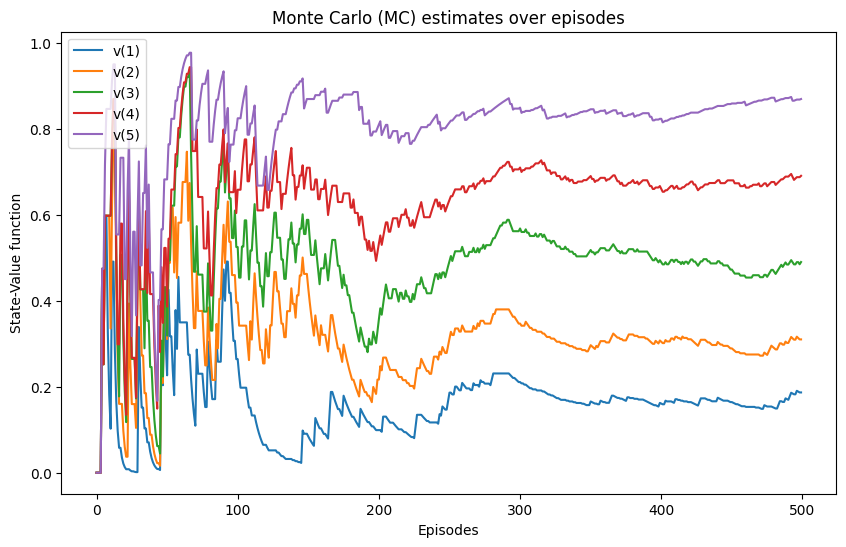

In [12]:
plt.figure(figsize=(10,6))
legends = ['v(1)','v(2)','v(3)','v(4)','v(5)']
plt.plot(v_mc_track[:,1:6])
plt.title('Monte Carlo (MC) estimates over episodes')
plt.ylabel('State-Value function')
plt.xlabel('Episodes')
plt.legend(legends)
plt.show()

The algorithm shows near-convergence to the true values. However, its **running estimates are very noisy**, they jump back and forth around the true values. We can run an experiment to calculate the **learning curve** to measure the performance using the root mean-squared (RMS) error between the value function learned and the true value function, averaged over the five states, then averaged over 100 runs:

In [48]:
from collections import defaultdict

def run_experiment(algorithm, runs, env, pi):
    v_runs = []
    for i in range(runs):
        _, v_td_track = algorithm(pi, env)
        v_runs.append(v_td_track)
    v_runs = np.array(v_runs) 
    
    # remove data about terminal states (which is always zero anyway)
    v_runs = v_runs[:,:,1:-1]  

    error_to_true = v_runs - env.v_true[1:-1]
    squared_error = np.power(error_to_true, 2)
    mean_squared_error = np.average(squared_error, axis=-1)
    root_mean_squared_error = np.sqrt(mean_squared_error)
    rmse_avg_over_runs = np.average(root_mean_squared_error, axis=0)
    
    return rmse_avg_over_runs

In [49]:
rmse_mc = run_experiment(mc, 100, random_walk, pi)

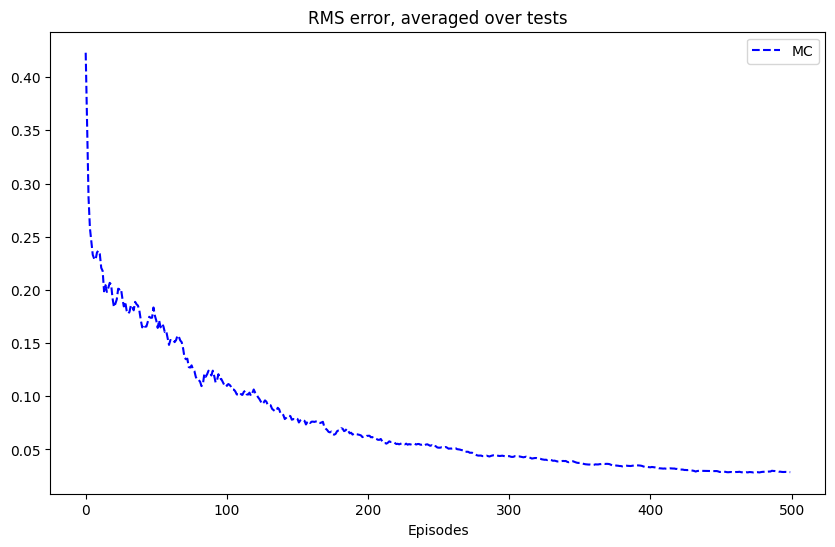

In [50]:
plt.figure(figsize=(10,6))
plt.plot(rmse_mc, color='blue', linestyle='--', label='MC')
plt.title('RMS error, averaged over tests')
plt.xlabel('Episodes')
plt.legend()
plt.show()

## Improving estimates after each step: Temporal-Difference Learning

MC has solid convergence properties, because it updates the value function estimate using the actual return, which is an unbiased estimate, however **the agent has to wait until the end of an episode** (when it obtain the return) before it can update the state-value function estimate, and this is a limitation. Moreover, the **actual returns are high-variance estimates** as they accumulate many random events in the same trajectory. All actions, all next states, all rewards are random events. The single return collects and compounds all of that randomness for multiple time steps (from t to T). So, **the single return is unbiased, but it has an high variance**. All of that randomness becomes noise that can only be alleviated with lots of trajectories. One way to diminish these issues of high variance and time is **to estimate a return instead of waiting for the actual value**. Notice that the agent is already calculating an estimate of the state-value function, so we can use a single-step reward and, once we observe the next state, we can use the current state-value function as an estimate of the return at the next step. 

![](./images/td-prediction.png)

This is the relationship in the equations that **temporal-difference (TD) methods** exploit:

$\displaystyle G_{t:T} = R_{t+1} + \gamma R_{t+2} + \gamma^2 R_{t+3} + ... + \gamma^{T-1} R_T$

$\displaystyle = R_{t+1} + \gamma (R_{t+2} + \gamma R_{t+3} + ... + \gamma^{T-2} R_T)$

$\displaystyle = R_{t+1} + \gamma G_{t+1:T}$

This means **we could estimate the return on every time step**. In order to make explict that we are using a single reward and then an estimate, we can use the subscript:

$\displaystyle G_{t:t+1} = R_{t+1} + \gamma V(S_{t+1})$

We can substitute in the formula for the evaluation of the state-value function:

$\displaystyle V(S_t) = V(S_t) + \alpha_t [G_{t:t+1} - V(S_t)]$

where $G_{t:t+1}$ is the **TD target** and $G_{t:t+1} - V(S_t)$ is the **TD error**. In other words, **TD methods estimate the state-value function using an estimate of the state-value function**. That reward signal **progressively "injects reality" into the estimates**. This way of **updating an estimate with an estimate** is referred to as **bootstrapping**. The TD estimate depends only on a single action, a single transition and a single reward, so there’s **much less randomness** being accumulated. As a consequence, TD methods usually learn **much faster** than MC methods. It can be seen as a **combination of Monte Carlo and Dynamic Programming ideas**. Like Monte Carlo, it learn directly from raw experience without a model of the environment’s dynamics. Like dynamic programming, it update estimates based in part on other learned estimates, without waiting for a final outcome. Dynamic Programming bootstraps on the one-step expectation while TD methods bootstrap **on a sample** of the one-step expectation. That word sample makes a whole lot of a difference. We can write the temporal-difference algorithm in Python: 

In [51]:
def td(pi, env, gamma=1.0, init_alpha=0.5, min_alpha=0.01, decay_episodes=350, n_episodes=500):

    # initialize the variables needed
    v = np.zeros(env.observation_space, dtype=float)
    v_track = np.zeros((n_episodes, env.observation_space), dtype=float)
    
    # calculate the learning rate schedule for all episodes
    alphas = decay_alpha(init_alpha, min_alpha, decay_episodes, n_episodes);
    
    # loop for n_episodes
    for e in range(n_episodes):
        
        # get the initial state and then enter the interaction loop
        state, done = env.reset(), False
        
        # get into the time step loop
        while not done:
            
            # sample the policy pi for the action to take in state
            action = pi(state)
            
            # use the action to interact with the environment... 
            # roll out the policy one step
            next_state, reward, terminated, truncated, info = env.step(action)
            if(terminated or truncated):
                done = True;
            
            # update the state value function
            td_target = reward + gamma * v[next_state] * (not done)
            td_error = td_target - v[state]
            v[state] = v[state] + alphas[e] * td_error
            
            # update the state variable for the next iteration
            state = next_state
            
        v_track[e] = v
        
    return v, v_track

Now we use the Temporal-Difference approach on the Random Walk environment:

In [52]:
v_td, v_td_track = td(pi, random_walk, n_episodes=500)

In [53]:
print(v_td)

[0.         0.17618576 0.35238214 0.53866601 0.70467667 0.85460073
 0.        ]


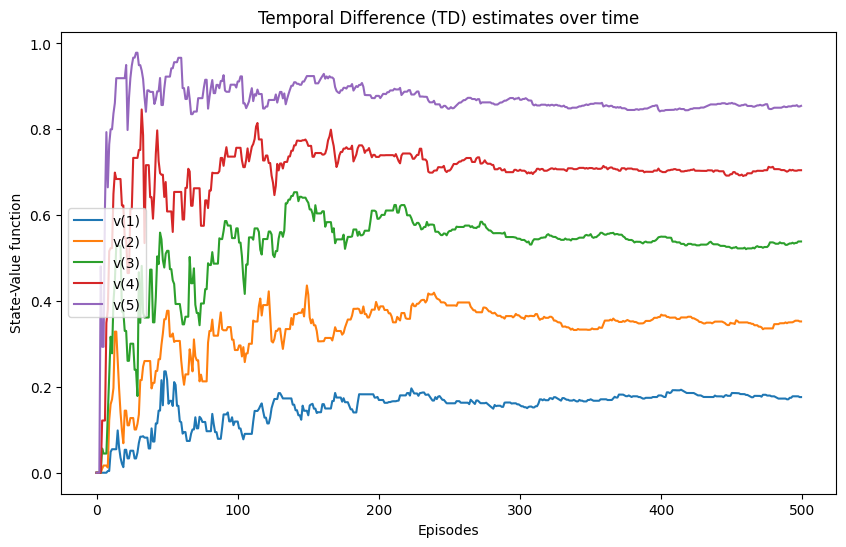

In [54]:
plt.figure(figsize=(10,6))
plt.plot(v_td_track[:,1:6])
plt.title('Temporal Difference (TD) estimates over time')
plt.ylabel('State-Value function')
plt.xlabel('Episodes')
plt.legend(legends)
plt.show()

While MC running estimates are very noisy, TD running estimates don’t jump as much, but they are off-center for most of the episodes.

In [55]:
rmse_td = run_experiment(td, 100, random_walk, pi)

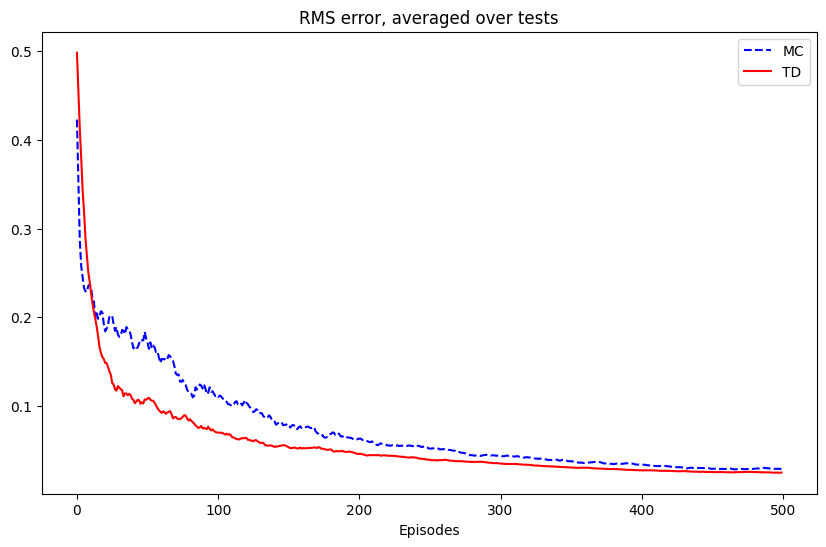

In [56]:
plt.figure(figsize=(10,6))
plt.plot(rmse_mc, color='blue', linestyle='--', label='MC')
plt.plot(rmse_td, color='red', linestyle='-', label='TD')
plt.title('RMS error, averaged over tests')
plt.xlabel('Episodes')
plt.legend()
plt.show()

At the beginning, both MC and TD methods start with a high error, indicating that the initial estimates of the value function are far from accurate. TD converges faster than MC, its line drops more rapidly in the first few episodes compared to the other. This indicates that TD is more efficient at reducing the error in the early stages of learning. As the number of episodes increases, both methods continue to reduce the error, but TD consistently performs better than MC. The TD line remains lower than the MC line throughout all the episodes, indicating that TD produces more accurate value function estimates on average. TD also appears to be more stable, with fewer fluctuations in error compared to MC, especially after the initial episodes. This suggests that TD might be better at handling noise in the learning process. Overall, the graph demonstrates that TD prediction is more efficient and effective than MC prediction in this scenario, leading to faster and more accurate convergence of the value function estimates.

## Batch updating

Suppose there is available only a **finite amount of experience**. In this case, a common approach is to **present the experience repeatedly** until the method converges upon an answer. We call this **batch updating** because updates are made only after processing each complete batch of training data. Under batch updating, TD and MC methods both converge but to **different answers**. Understanding these two answers will help us understand the difference between the two methods. Suppose we observe the following eight episodes:

- Episode 1: A, 0, B, 0 
- Episode 2: B, 1
- Episode 3: B, 1 
- Episode 4: B, 1
- Episode 5: B, 1 
- Episode 6: B, 1
- Episode 7: B, 1 
- Episode 8: B, 0

The first episode started in state A, transitioned to B with a reward of 0, and then terminated from B with a reward of 0. The other seven episodes were even shorter, starting from B and terminating immediately. Given this batch of data, what would we say are the optimal predictions, the best values for the estimates V(A) and V(B)? Everyone would probably agree that the optimal value for V(B) is 3/4, because six out of the eight times in state B the process terminated immediately with a return of 1, and the other two times in B the process terminated immediately with a return of 0. But what is the optimal value for the estimate V(A)? Here there are two reasonable answers. One is to observe that all the times the process was in state A, it traversed immediately to B; and because we have already decided that B has value 3/4, therefore A must have value 3/4 as well. This is also the answer that TD gives. The other reasonable answer is simply to observe that we have seen A once and the return that followed it was 0; we therefore estimate V(A) as 0. This is the answer that MC gives. The second answer gives minimum squared error on the training data, but we expect the first answer to be better. If the process is markovian, we expect that the first answer will produce lower error on future data, even though the MC answer is better on the existing data. This illustrates a general difference between the estimates found by TD and MC methods. MC always find the estimates that **minimize mean-squared error on the training set**, whereas TD always finds the **estimates for the model of the Markov process**. The model used by TD is **formed from the observed episodes**: the transition probability from i to j is the fraction of observed transitions from i that went to j, and the associated expected reward is the average of the rewards observed on those transitions. Given this model, we can compute the estimate of the value function that would be exactly correct if the model were exactly correct. This is called the **certainty-equivalence estimate** because it is equivalent to assuming that the estimate of the underlying process was known with certainty rather than being approximated. This helps explain why TD method converges more quickly than MC method. Although the non-batch methods do not achieve the certainty-equivalence or the minimum squared-error estimates, they can be understood as moving roughly in these directions. Non-batch TD may be faster than MC because it is moving toward a better estimate, even though it is not getting all the way there.

## Improving estimates after multiple steps: n-steps TD

In MC we sample the environment all the way through the end of the episode before we estimate the value function. On the other hand, in TD the agent interacts with the environment only once, and it calculate a new estimates of the value function exploiting the current estimate. But, **is there something in between?**. 

![](./images/middle-mc-td.png)

TD bootstraps after one step, but how about after two steps? Three? Four? How many steps should we wait before we estimate the expected return and bootstrap on the value function? There’s a spectrum of algorithms lying in between MC and TD. We can **tune how much bootstrapping**, letting us **balance bias and variance**. We have two extremes (MC and TD methods): MC is an **infinite-step method** (it goes all the way until the end of the episode), TD is a **one-step method** (it interacts with the environment for a single step). We can generalize into an **n-step method**: instead of doing a single step (like TD) or the full episode (like MC), **it uses n-steps to calculate value functions**. This method is called **n-step TD**. We wait n steps before update the state-value function estimation:

$\displaystyle S_{t}, A_{t}, R_{t+1}, S_{t+1}, ... ,R_{t+n}, S_{t+n}$

The number of steps can be less then n if the agent reaches a terminal state before, however it could not be more than n. Once we have these n steps, we can rewrite the equation exploiting the information we collect. Considering the entire episode (MC):

$\displaystyle G_{t:T} = R_{t+1} + \gamma R_{t+2} + ... + \gamma^{T-1}R_T$

$\displaystyle V(S_t) = V(S_t) + \alpha_t [G_{t:T} - V(S_t)]$

Considering just one step (TD):

$\displaystyle G_{t:t+1} = R_{t+1} + \gamma V(S_{t+1})$

$\displaystyle V(S_t) = V(S_t) + \alpha_t [G_{t:t+1} - V(S_t)]$

If we can use n steps:

$\displaystyle G_{t:t+n} = R_{t+1} + \gamma R_{t+2} + ... + \gamma^{n-1} R_{t+n} + \gamma^{n} V(S_{t+n})$

$\displaystyle V(S_t) = V(S_t) + \alpha_t [G_{t:t+n} - V(S_t)]$

where $G_{t:t+n}$ is the **n-step TD target** and $G_{t:t+n} - V(S_t)$ is the **n-step TD error**. When can implement it in Python, notice that it is a hybrid between MC and TD: we need to generate some steps, but instead of going to the end of the episode (like in MC) implementation, we go to  n steps before bootstrapping the estimate: 

In [57]:
def generate_path(pi, env, state, n_steps):

    # list of experiences along the path (part of a trajectory)
    path = []

    done = False
    
    # looping through until the path length is equal to n_steps
    while len(path) < n_steps:

        # use the policy function to pick an action
        action = pi(state);

        # step the environment using that action
        next_state, reward, terminated, truncated, info = env.step(action)
        if(terminated or truncated):
            done = True;

        # append the experience to the path
        experience = (state, action, reward, next_state, done)
        path.append(experience)

        # if we hit a terminal state before n_steps, break and return
        if done: 
            break

        # update the state
        state = next_state

    # return the path
    return np.array(path, object)

Now we can use the path to implement the n-step TD method:

In [58]:
def ntd(pi, env, gamma=1.0, n_steps=3, init_alpha=0.5, min_alpha=0.01, decay_episodes=350, n_episodes=500):    
    # calculate n_step discounts at once 
    discounts = decay_discounts(gamma, n_steps+1);
    
    # calculate all alphas at once
    alphas = decay_alpha(init_alpha, min_alpha, decay_episodes, n_episodes);
      
    # initialize the current estimate of the state-value function
    v = np.zeros(env.observation_space, dtype=float)

    # create a list to save copies of v for offline analysis
    v_track = np.zeros((n_episodes, env.observation_space), dtype=float)
    
    # loop for every episode 
    for e in range(n_episodes):

        # get the initial state
        state, done = env.reset(), False

        # go collecting a series of n-state paths until we hit done
        while not done:

            # generate a path of n-steps (maximum, or less if we hit done)
            path = generate_path(pi, env, state, n_steps)
            
            # calculate the number of steps, could be ‘n_step’ but it could 
            # also be smaller if a terminal state is in the path    
            n = len(path)
        
            # initialize a visits check vector
            visited = np.zeros(env.observation_space, dtype=bool)
        
            # now loop through all experiences in the path
            for t, (state, _, reward, next_state, done) in enumerate(path):                
                
                # calculate the partial return
                partial_return = np.sum(discounts[:n-t] * path[t:, 2])
            
                # update the value function
                ntd_target = partial_return + discounts[n] * v[path[n-1, 3]]
                ntd_error = ntd_target - v[state]
                v[state] = v[state] + alphas[e] * ntd_error
                                           
                state = next_state
                
        # keep track of the episode’s V
        v_track[e] = v
                      
    return v.copy(), v_track

We can apply this method to the Random Walk environment using a 3-step TD:

In [59]:
v_ntd, v_ntd_track = ntd(pi, random_walk, n_steps=3, n_episodes=500)

In [60]:
print(v_ntd)

[0.         0.16004448 0.33393513 0.4931261  0.6482914  0.84844146
 0.        ]


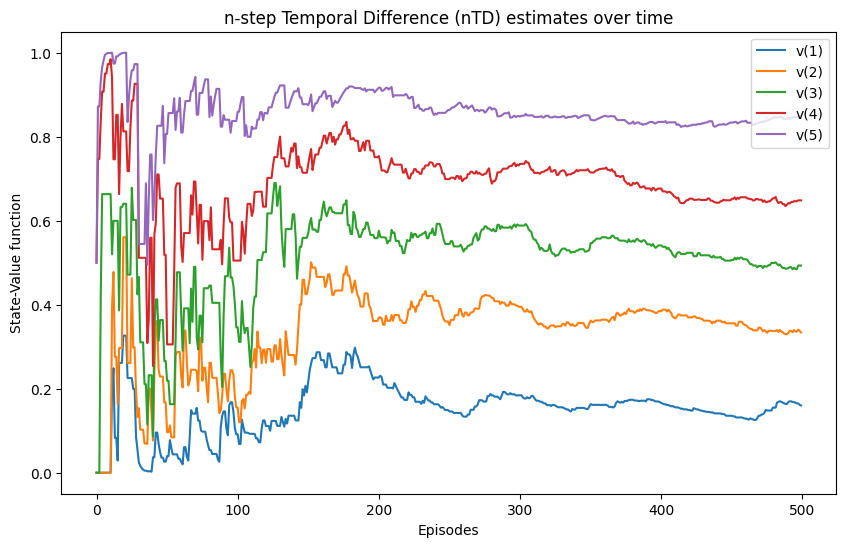

In [61]:
plt.figure(figsize=(10,6))
plt.plot(v_ntd_track[:,1:6])
plt.title('n-step Temporal Difference (nTD) estimates over time')
plt.ylabel('State-Value function')
plt.xlabel('Episodes')
plt.legend(legends)
plt.show()

We can compare with the TD, MC:

In [62]:
rmse_ntd = run_experiment(ntd, 100, random_walk, pi)

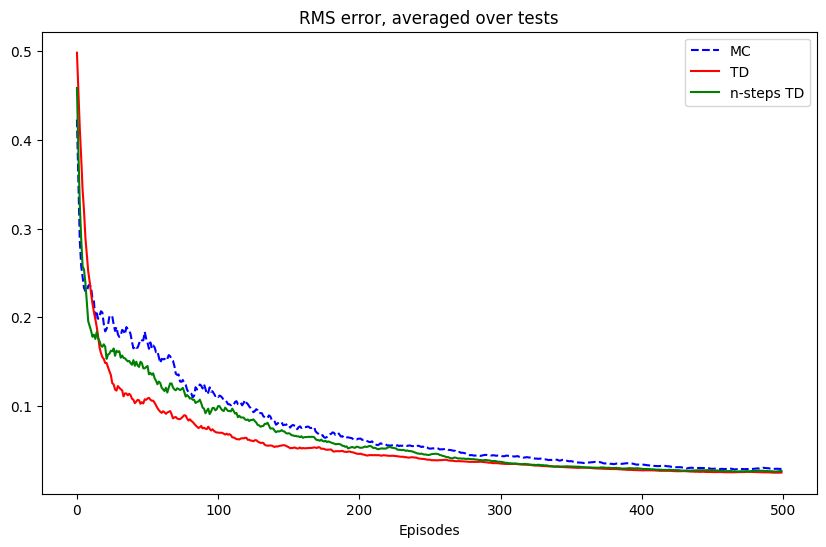

In [63]:
plt.figure(figsize=(10,6))
plt.plot(rmse_mc, color='blue', linestyle='--', label='MC')
plt.plot(rmse_td, color='red', linestyle='-', label='TD')
plt.plot(rmse_ntd, color='green', linestyle='-', label='n-steps TD')
plt.title('RMS error, averaged over tests')
plt.xlabel('Episodes')
plt.legend()
plt.show()

The n-step TD strikes a balance between MC and TD, offering faster convergence than MC but slightly slower than TD. It updates the value estimates using rewards over a few steps and this can **reduces bias (compared to TD)** by considering more actual rewards and **reduces variance (compared to MC)** because it does not wait until the end of the episode. This often leads to **more stable and robust learning**, particularly in environments where rewards are sparse or delayed. However, the **choice of n is crucial**. If n is too small, the algorithm will have high bias and low variance, similar to TD. If n is too large, the algorithm will have low bias and high variance, similar to MC. The optimal value of n depends on the environment and the task.

## Improving estimates of all visited states: TD($\lambda$)

A question emerges, what is a good value for the parameter n? How many steps should the agent wait before updating the value function? How about using a weighted combination of all n-step targets as a single target? The agent could go out, calculates the n-step targets corresponding to the one-, two-, three-, ..., infinite-step target and then **combines all of these targets with an exponentially decaying factor**. This is called **forward-view TD($\lambda$)** method. We can introduce a new parameter **lambda** to control the weighting of the n-step targets in the following way:

- $\lambda$ = 0: TD($\lambda$) should become equivalent to TD learning (for this reason TD is often referred to as TD(0));
- $\lambda$ = 1: TD($\lambda$) should become equivalent to MC;
- 0 < $\lambda$ < 1: TD($\lambda$) should consider multiple steps of future rewards, combining short-term and long-term updates.

![](./images/td-lambda.png)

$\displaystyle G_{t:t+1} = R_{t+1} + \gamma V(S_{t+1})$

$\displaystyle G_{t:t+2} = R_{t+1} + \gamma R_{t+2} + \gamma^2 V(S_{t+2})$

...

$\displaystyle G_{t:t+n} = R_{t+1} + \gamma R_{t+2} + ... + \gamma^{n-1} R_{t+n} + \gamma^{n} V(S_{t+n})$

...

$\displaystyle G_{t:T} = R_{t+1} + \gamma R_{t+2} + ... + \gamma^{T-1}R_T$

We can compose all targets using a weighted sum:

$\displaystyle G^\lambda_{t:T} = (1 - \lambda)  \sum\limits_{n=1}^{T-t-1}{\lambda^{n-1}G_{t:t+n}} + \lambda^{T-t-1}G_{t:T}$

In the end, we can evaluate the estimate of the value function using this return:

$\displaystyle V(S_t) = V(S_t) + \alpha_t [G^{\lambda}_{t:T} - V(S_t)]$

where $G^{\lambda}_{t:T}$ is the **TD($\lambda$) target** and $G^{\lambda}_{t:T} - V(S_t)$ is the **TD($\lambda$) error**. 

In this way, forward-view TD(λ) looks ahead to all possible future rewards from the current state and combines them into a single value update, with the contribution of each future reward decaying over time according to the parameter. t provides a way to smoothly interpolate between **short-term learning** (like TD) and **long-term learning** (like MC). However, like MC, it is under **the curse of the time step**, because it can update the state-value function only after reaching a terminal state.

In practice, this idea is typically implemented using a **backward view**, in order to overcome the need to wait until the end of the episode to apply updates.  We exploit the idea of **eligibility trace**. It is a memory that keeps track of how much each state should be credited for future rewards. When a state is visited, its eligibility trace is increased and as time progresses, its trace decays (using a parameter). The fading traces allow the agent to "remember" and update not just the most recent state but a sequence of past states, with a decreasing emphasis the further back in time they were visited:

![](./images/eligibility-traces.png)

At each time step, the algorithm updates value estimates not only for the current state but for all previously visited states (so withs backward view), weighted by their eligibility traces. The method is called, **backward-view TD($\lambda$)**. At the begging of every new episode, we set the eligibility vector to zero:

$\displaystyle E = 0$

then, we interact with the environment for one step:

$\displaystyle S_{t}, A_{t}, R_{t+1}, S_{t+1}$

we encounter a state and we add one to its trace, in order to mark it as eligible for an update: 

$\displaystyle E(S_t) = E(S_t) + 1$

we then calculate the TD error just as we’ve done so far for TD:

$\displaystyle \delta^{TD}_{t:t+1}(S_t) = R_{t+1} + \gamma V(S_{t+1}) - V(S_t)$

however, we can apply the update to the value function **for all states that are eligible** by multipling it by the eligibility trace vector. In this way, only eligible states will get updated:

$\displaystyle V = V + \alpha_t \delta^{TD}_{t:t+1}(S_t) E$

Notice that we are not updating only $V(S_t)$ but all vector $V$ instead, this is because we’re multiplying by the eligibility vector E, so the eligible states get the corresponding credit.  After each update, the eligibility trace vector is decayed, so that future reinforcing events have less impact on earlier states. By doing this, the most recent states get more significant credit for a reward encountered in a recent transition than those states visited earlier in the episode:

$\displaystyle E = \lambda E$

We can implement the algorithm in Python:

In [65]:
def td_lambda(pi, env, gamma=1.0, lambda_=0.2, 
              init_alpha=0.5, min_alpha=0.01, 
              decay_episodes=350, n_episodes=500):

    # calculate all alphas at once
    alphas = decay_alpha(init_alpha, min_alpha, decay_episodes, n_episodes);

    # initialize the current estimate of the state-value function
    v = np.zeros(env.observation_space, dtype=float)

    # create a list to save copies of v for offline analysis
    v_track = np.zeros((n_episodes, env.observation_space), dtype=float)
    
    # initialize the eligibility trace vector
    E = np.zeros(env.observation_space, dtype=float)
    
    # loop for every episode
    for e in range(n_episodes):
        
        # set E to zero every new episode
        E.fill(0)
        
        # get the initial state
        state, done = env.reset(), False
        
        # get into the time step loop
        while not done:
            
            # sample the policy pi for the action to take in state
            action = pi(state)
            
            # interact with the environment for one step and get the experience tuple
            next_state, reward, terminated, truncated, info = env.step(action)
            if(terminated or truncated):
                done = True;
            
            # use that experience to calculate the TD error as usual
            td_target = reward + gamma * v[next_state] * (not done)
            td_error = td_target - v[state]
            
            # increment the eligibility of state by 1
            E[state] = E[state] + 1
            
            # apply the error update to all eligible states as indicated by E
            v = v + alphas[e] * td_error * E
            
            # decay E
            E = lambda_ * E
            
            # update the state variable for the next iteration
            state = next_state
            
        v_track[e] = v

    return v, v_track

We can apply this method to the random walk environment:

In [66]:
v_td_lambda, v_td_lambda_track = td_lambda(pi, random_walk, lambda_=0.3, n_episodes=500)

In [67]:
print(v_td_lambda)

[0.         0.19140136 0.39634172 0.5694172  0.72568936 0.87365462
 0.        ]


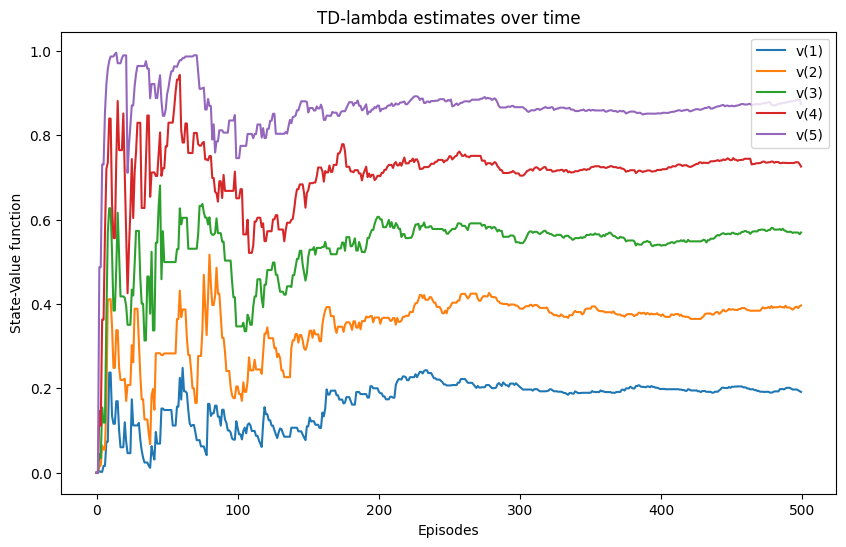

In [69]:
plt.figure(figsize=(10,6))
plt.plot(v_td_lambda_track[:,1:6])
plt.title('TD-lambda estimates over time')
plt.ylabel('State-Value function')
plt.xlabel('Episodes')
plt.legend(legends)
plt.show()

And we can compare with the other methods:

In [70]:
rmse_td_lamda = run_experiment(td_lambda, 100, random_walk, pi)

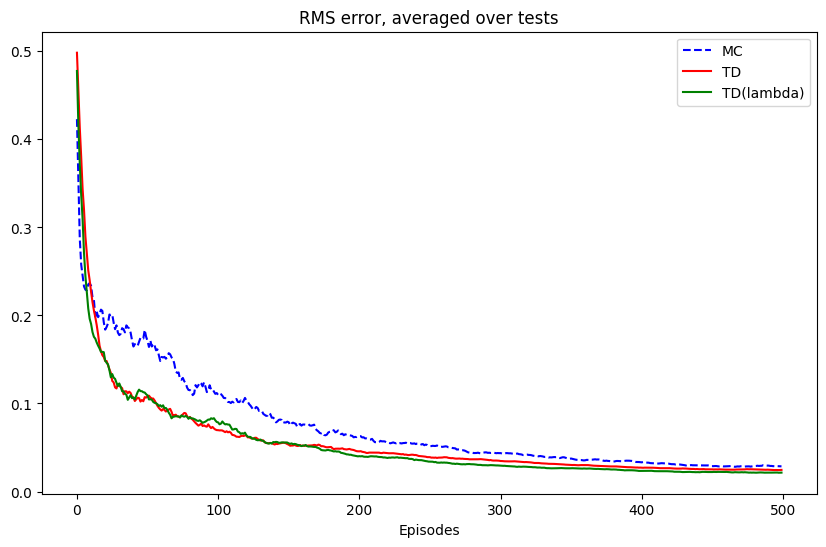

In [72]:
plt.figure(figsize=(10,6))
plt.plot(rmse_mc, color='blue', linestyle='--', label='MC')
plt.plot(rmse_td, color='red', linestyle='-', label='TD')
plt.plot(rmse_td_lamda, color='green', linestyle='-', label='TD(lambda)')
plt.title('RMS error, averaged over tests')
plt.xlabel('Episodes')
plt.legend()
plt.show()

The graph shows that TD($\lambda$) is the most effective method, providing faster convergence and more accurate value function estimates.